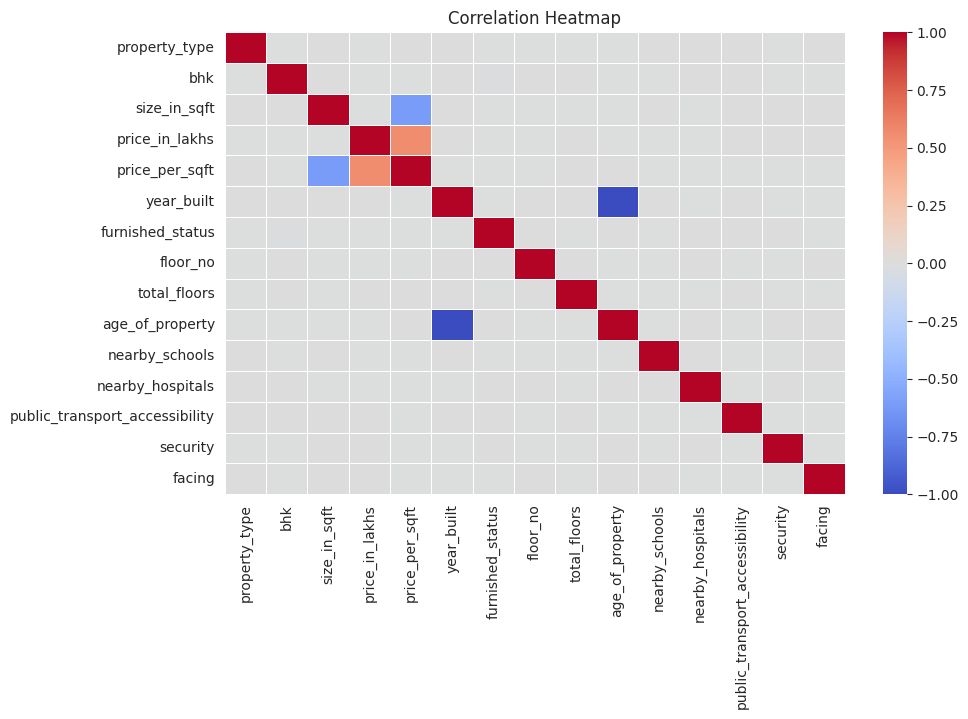

--- 1. Linear Regression (Baseline) ---

--- 2. Decision Tree Tuning ---


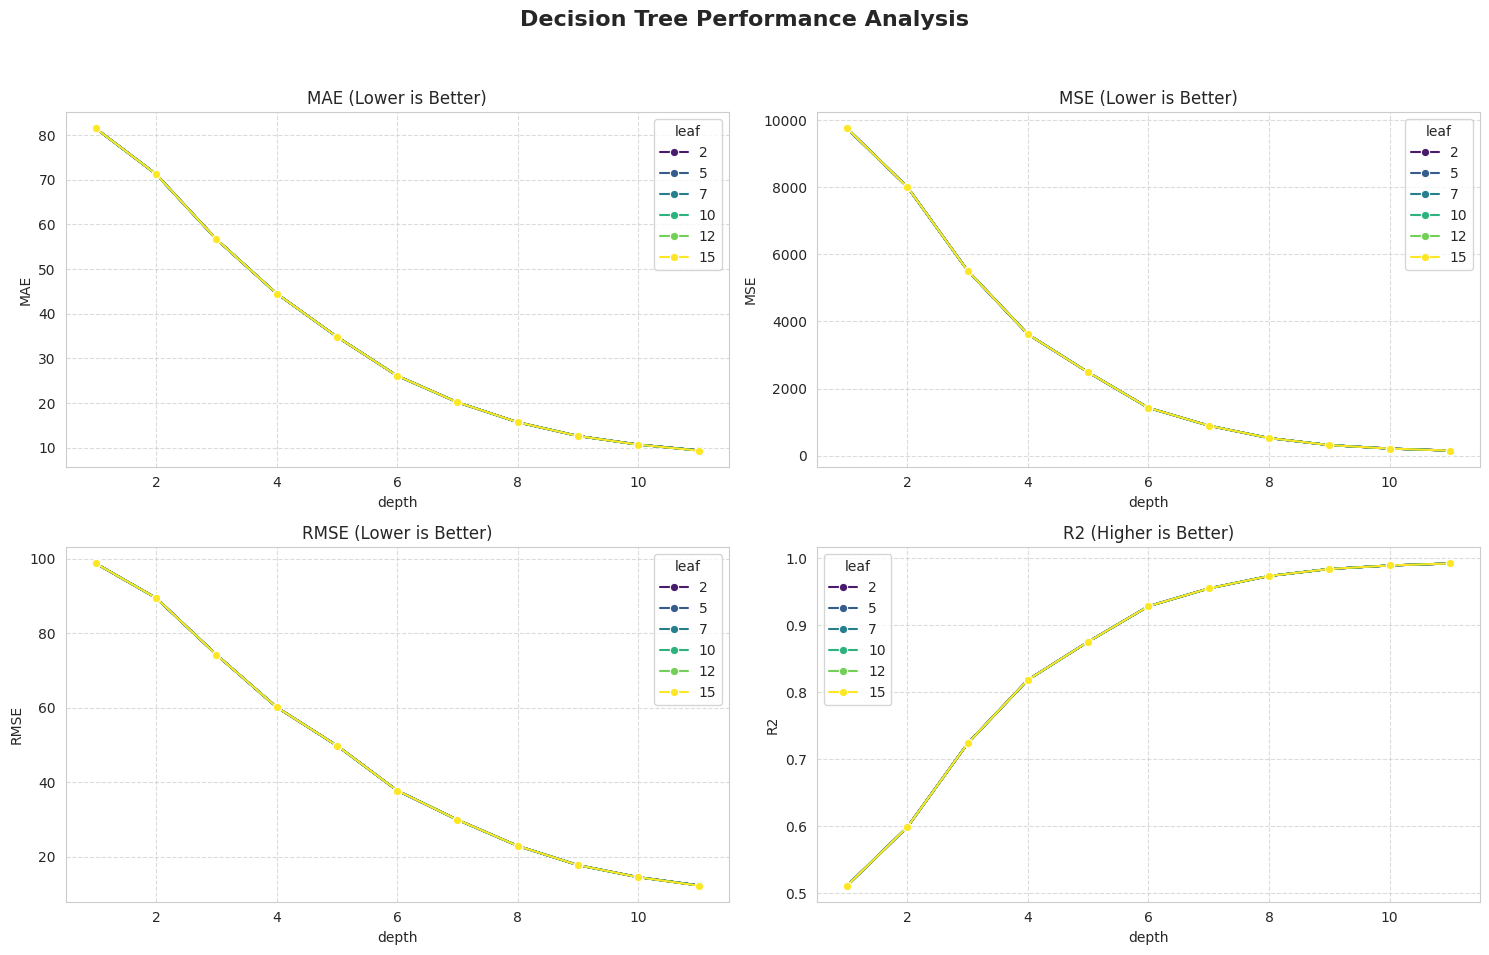

Selected DT: Depth=11.0, Leaf=15.0

--- 3. Random Forest (Sequential Tuning) ---
Step A: Tuning N_Estimators (Fixing Depth=20, Leaf=1)


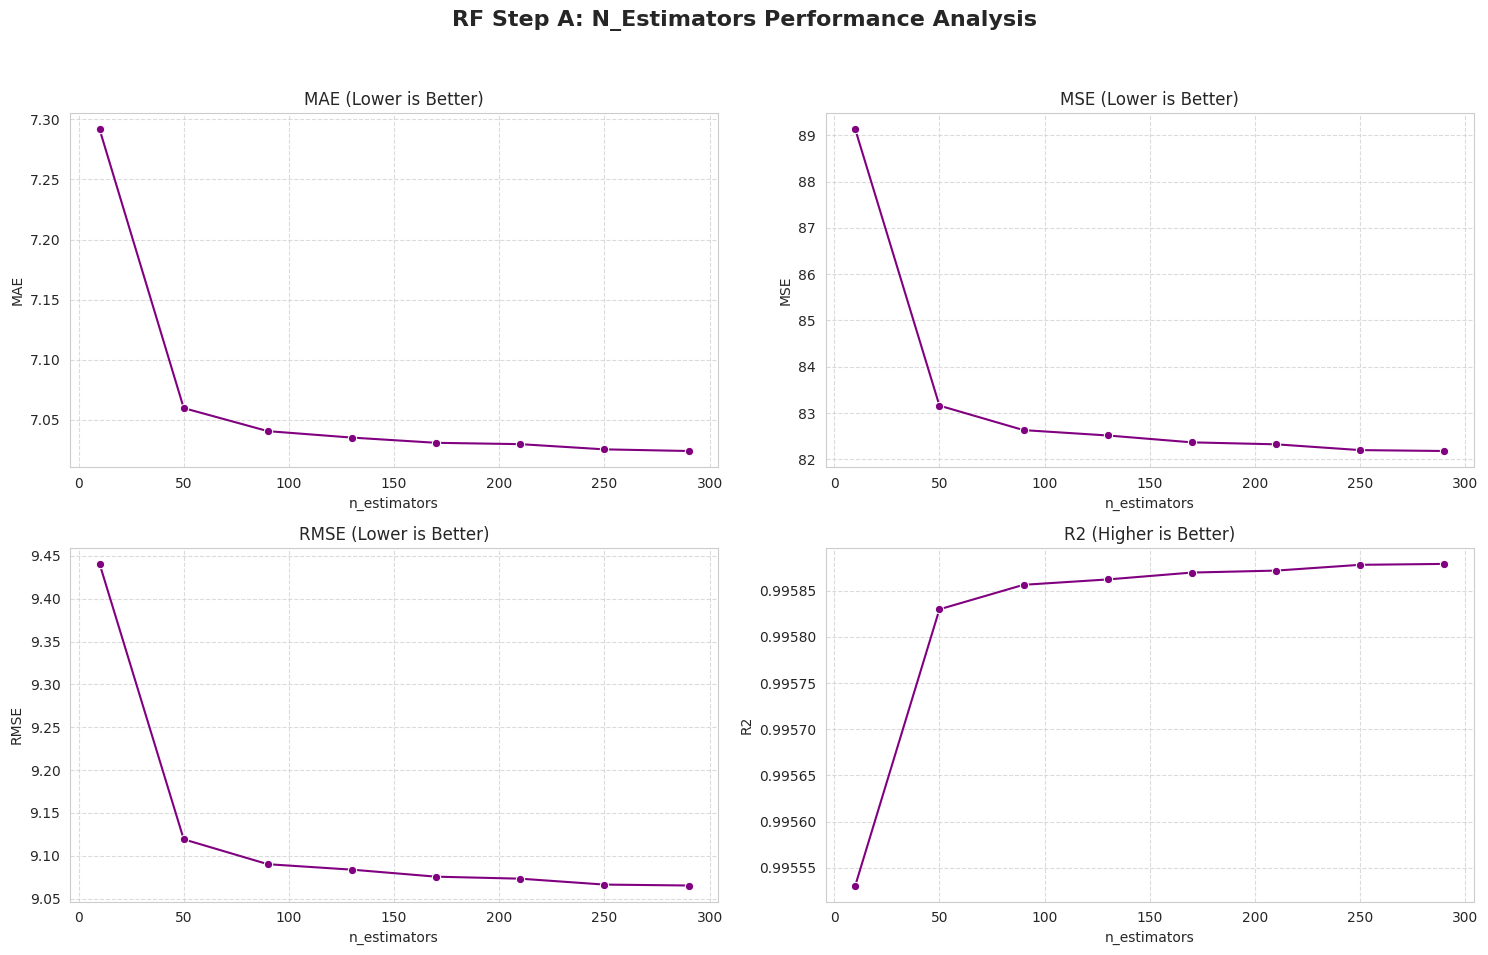

-> Selected Best N_Estimators: 290
Step B: Tuning Max_Depth (Using N=290)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor

# Visual settings
sns.set_style("whitegrid")
%matplotlib inline 

# ==========================================
# 1. DATA PREPARATION (STRICT LOWERCASE)
# ==========================================

df_sampled = pd.read_csv("data/india_housing_prices.csv")
df = df_sampled.sample(frac=0.4, random_state=1).copy()

# Force lowercase on column names
df.columns = df.columns.str.lower()

# Force lowercase on all string values
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].str.lower()

# Drop irrelevant columns
df.drop(['id', 'locality'], axis=1, inplace=True, errors='ignore')

# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# Encoding
ordinal_cols = ['property_type', 'furnished_status', 'public_transport_accessibility', 'facing', 'security']
categories = [
    ['apartment', 'independent house', 'villa'],
    ['unfurnished', 'semi-furnished', 'furnished'],
    ['low', 'medium', 'high'],
    ['south', 'east', 'west', 'north'], 
    ['no', 'yes']
]

encoder = OrdinalEncoder(categories=categories)
df[ordinal_cols] = encoder.fit_transform(df[ordinal_cols])

# Correlation Heatmap
plt.figure(figsize=(10, 6))
numerical_cols = df.select_dtypes(exclude=['object']).columns
sns.heatmap(df[numerical_cols].corr(), cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Splitting
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.price_in_lakhs.values
y_val = df_val.price_in_lakhs.values
y_test = df_test.price_in_lakhs.values

del df_train['price_in_lakhs']
del df_val['price_in_lakhs']
del df_test['price_in_lakhs']

# Vectorization
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# --- Helper Functions ---

model_results = []

def evaluate_model(y_true, y_pred, model_name=None):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    if model_name:
        return {"Model": model_name, "MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}
    return mae, mse, rmse, r2

def plot_tuning_metrics(df_scores, x_axis, hue=None, title_prefix="Model"):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{title_prefix} Performance Analysis', fontsize=16, fontweight='bold')
    
    metrics = ['mae', 'mse', 'rmse', 'r2']
    titles = ['MAE (Lower is Better)', 'MSE (Lower is Better)', 'RMSE (Lower is Better)', 'R2 (Higher is Better)']
    
    for i, metric in enumerate(metrics):
        row, col = i // 2, i % 2
        ax = axes[row, col]
        
        use_hue = hue if hue in df_scores.columns else None
        
        if use_hue:
            if pd.api.types.is_numeric_dtype(df_scores[use_hue]):
                 sns.lineplot(data=df_scores, x=x_axis, y=metric, hue=use_hue, marker='o', palette='viridis', ax=ax)
            else:
                 sns.lineplot(data=df_scores, x=x_axis, y=metric, hue=use_hue, marker='o', ax=ax)
        else:
            sns.lineplot(data=df_scores, x=x_axis, y=metric, marker='o', color='purple', ax=ax)
            
        ax.set_title(titles[i])
        ax.set_ylabel(metric.upper())
        ax.set_xlabel(x_axis)
        ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==========================================
# 2. SEQUENTIAL TUNING PIPELINE
# ==========================================

print("--- 1. Linear Regression (Baseline) ---")
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
model_results.append(evaluate_model(y_val, y_pred, "Linear Regression"))


print("\n--- 2. Decision Tree Tuning ---")
scores = []
for depth in range(1, 12): 
    for leaf in [1, 3, 4, 5, 6, 8, 10, 15]:
        dt = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=leaf, random_state=1)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_val)
        mae, mse, rmse, r2 = evaluate_model(y_val, y_pred)
        scores.append((depth, leaf, mae, mse, rmse, r2))

df_scores_dt = pd.DataFrame(scores, columns=['depth', 'leaf', 'mae', 'mse', 'rmse', 'r2'])
plot_tuning_metrics(df_scores_dt, x_axis='depth', hue='leaf', title_prefix="Decision Tree")

best_row = df_scores_dt.loc[df_scores_dt['r2'].idxmax()]
print(f"Selected DT: Depth={best_row['depth']}, Leaf={best_row['leaf']}")
dt = DecisionTreeRegressor(max_depth=int(best_row['depth']), 
                           min_samples_leaf=int(best_row['leaf']), 
                           random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)
model_results.append(evaluate_model(y_val, y_pred, "Decision Tree"))


print("\n--- 3. Random Forest (Sequential Tuning) ---")

# --- Step A: Tune N_Estimators ---
print("Step A: Tuning N_Estimators (Fixing Depth=20, Leaf=1)")
scores = []
for n in range(10, 301, 40):
    rf = RandomForestRegressor(n_estimators=n, max_depth=20, min_samples_leaf=1, 
                               random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mae, mse, rmse, r2 = evaluate_model(y_val, y_pred)
    scores.append((n, mae, mse, rmse, r2))

df_scores_a = pd.DataFrame(scores, columns=['n_estimators', 'mae', 'mse', 'rmse', 'r2'])
plot_tuning_metrics(df_scores_a, x_axis='n_estimators', title_prefix="RF Step A: N_Estimators")

# Pick Best N
best_n = int(df_scores_a.loc[df_scores_a['r2'].idxmax()]['n_estimators'])
print(f"-> Selected Best N_Estimators: {best_n}")


# --- Step B: Tune Max_Depth (Using Best N) ---
print(f"Step B: Tuning Max_Depth (Using N={best_n})")
scores = []
for d in [1, 3, 5, 10, 20, 25, 35, 50, None]:
    rf = RandomForestRegressor(n_estimators=best_n, max_depth=d, min_samples_leaf=1, 
                               random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mae, mse, rmse, r2 = evaluate_model(y_val, y_pred)
    d_label = str(d) if d is not None else "None"
    scores.append((d_label, mae, mse, rmse, r2))

df_scores_b = pd.DataFrame(scores, columns=['depth', 'mae', 'mse', 'rmse', 'r2'])
plot_tuning_metrics(df_scores_b, x_axis='depth', title_prefix="RF Step B: Max_Depth")

# Pick Best Depth
best_depth_str = df_scores_b.loc[df_scores_b['r2'].idxmax()]['depth']
best_depth = None if best_depth_str == "None" else int(best_depth_str)
print(f"-> Selected Best Max_Depth: {best_depth}")


# --- Step C: Tune Min_Samples_Leaf (Using Best N & D) ---
print(f"Step C: Tuning Min_Samples_Leaf (Using N={best_n}, D={best_depth})")
scores = []
for leaf in [1, 3, 5, 10, 20, 35]:
    rf = RandomForestRegressor(n_estimators=best_n, max_depth=best_depth, min_samples_leaf=leaf, 
                               random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mae, mse, rmse, r2 = evaluate_model(y_val, y_pred)
    scores.append((leaf, mae, mse, rmse, r2))

df_scores_c = pd.DataFrame(scores, columns=['leaf', 'mae', 'mse', 'rmse', 'r2'])
plot_tuning_metrics(df_scores_c, x_axis='leaf', title_prefix="RF Step C: Min_Leaf")

# Pick Best Leaf
best_leaf = int(df_scores_c.loc[df_scores_c['r2'].idxmax()]['leaf'])
print(f"-> Selected Best Min_Samples_Leaf: {best_leaf}")


# --- Final Random Forest Model ---
print("\nTraining Final Random Forest...")
rf_final = RandomForestRegressor(n_estimators=best_n, max_depth=best_depth, min_samples_leaf=best_leaf, 
                                 random_state=1, n_jobs=-1)
rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_val)
model_results.append(evaluate_model(y_val, y_pred, "Random Forest"))


print("\n--- 4. XGBoost Tuning (GridSearchCV) ---")
# Using GridSearchCV as originally requested
param_grid = {
    'tree_method': ['hist'],
    'device': ['cpu'],  # Change to 'cuda' for GPU
    'n_estimators': [100],
    'max_depth': [3, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=1)

scoring_metrics = {
    'r2': 'r2',
    'neg_mae': 'neg_mean_absolute_error',
    'neg_mse': 'neg_mean_squared_error'
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=scoring_metrics,
    refit='r2', 
    cv=3,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Parsing Results for Visualization
results = pd.DataFrame(grid_search.cv_results_)
results['mae'] = -results['mean_test_neg_mae']
results['mse'] = -results['mean_test_neg_mse']
results['rmse'] = np.sqrt(results['mse'])
results['r2'] = results['mean_test_r2']
results['depth'] = results['param_max_depth']
results['learning_rate'] = results['param_learning_rate']

plot_tuning_metrics(results, x_axis='learning_rate', hue='depth', title_prefix="XGBoost (GridSearch)")

print(f"Best XGB Params: {grid_search.best_params_}")
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_val)
model_results.append(evaluate_model(y_val, y_pred, "XGBoost"))


# ==========================================
# 3. FINAL RESULTS DASHBOARD
# ==========================================

df_res = pd.DataFrame(model_results)
print("\nFinal Metrics Summary:")
display(df_res)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Final Model Performance Comparison', fontsize=16, fontweight='bold')

metrics_config = [
    ('MAE', axes[0, 0], 'MAE (Lower is Better)', 'viridis'),
    ('MSE', axes[0, 1], 'MSE (Lower is Better)', 'magma'),
    ('RMSE', axes[1, 0], 'RMSE (Lower is Better)', 'plasma'),
    ('R2', axes[1, 1], 'R2 Score (Higher is Better)', 'cividis')
]

for metric, ax, title, palette in metrics_config:
    sns.barplot(data=df_res, x='Model', y=metric, hue='Model', legend=False, palette=palette, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('')
    
    for i, v in enumerate(df_res[metric]):
        offset = v * 0.01 if v >= 0 else v * 0.05
        fmt = '.0f' if metric == 'MSE' else '.3f'
        ax.text(i, v + offset, f'{v:{fmt}}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()